In [88]:
import matplotlib.pyplot as plt
import pandas as pd

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, accuracy_score

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.svm import SVC
from keras.models import Sequential
from keras.layers import Dense
from keras import regularizers
from keras.layers import Dropout
from keras.callbacks import EarlyStopping

from imblearn.over_sampling import SMOTE

%matplotlib inline

## Load the MIMIC data

In [3]:
df = pd.read_csv('../data/MIMIC_train_test.csv')
df.drop(columns='Unnamed: 0',inplace=True)
df.head()

,HADM_ID,text_list,label
0,100009,Admission Date Dischar...,0
1,100034,Admission Date Dischar...,0
2,100045,Admission Date Dischar...,0
3,100059,Admission Date Discharge Date...,0
4,100099,Admission Date Dischar...,0


In [4]:
df.shape

(6483, 3)

## Prepare Text Data for Machine Learning

In [5]:
# The base line for this dataset
base = round(len(df[df['label']==0])/(len(df)),4)
print(f'The base line is {base}')

The base line is 0.9267


In [14]:
# Split the train and test data
X = df['text_list']
y = df['label']

X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    random_state = 42)

In [15]:
y.value_counts()

0    6008
1     475
Name: label, dtype: int64

In [16]:
y_train.value_counts(normalize=True)

0    0.925134
1    0.074866
Name: label, dtype: float64

In [17]:
y_test.value_counts(normalize=True)

0    0.931524
1    0.068476
Name: label, dtype: float64

## Vectorization NLP 

In [10]:
# Create a function to fit and transform dataset to 2 kinds of Vectorizer
def vectorizing(vec_name):
    return vec_name.fit_transform(X_train), vec_name.transform(X_test)

In [18]:
# Use default CountVectorizer and TfidfVecterizer parameter
# The default parameter won't work, because model failed to converge
# Use max_features = 200
cvec = CountVectorizer(max_features=100, stop_words='english')
X_train_cvec, X_test_cvec = vectorizing(cvec)
tfidf = TfidfVectorizer(max_features=100, stop_words='english')
X_train_tfidf, X_test_tfidf = vectorizing(tfidf)

In [30]:
y_test.shape

(1621,)

### CountVectorizer, Train & Test

In [25]:
# Create the balanced training set and testing set seperately
smt = SMOTE()
X_train_cvec, y_train_cvec = smt.fit_sample(X_train_cvec, y_train)
y_train_cvec.value_counts(normalize=True)

1    0.5
0    0.5
Name: label, dtype: float64

In [31]:
X_test_cvec, y_test_cvec = smt.fit_sample(X_test_cvec, y_test)
y_test_cvec.value_counts(normalize=True)

1    0.5
0    0.5
Name: label, dtype: float64

In [36]:
print(X_train_cvec.shape, X_test_cvec.shape, y_train_cvec.shape, y_test_cvec.shape)

(8996, 100) (3020, 100) (8996,) (3020,)


### TfidfVectorizer, Train & Test

In [32]:
# Create the balanced training set and testing set seperately
smt = SMOTE()
X_train_tfidf, y_train_tfidf = smt.fit_sample(X_train_tfidf, y_train)
y_train_tfidf.value_counts(normalize=True)

1    0.5
0    0.5
Name: label, dtype: float64

In [34]:
X_test_tfidf, y_test_tfidf = smt.fit_sample(X_test_tfidf, y_test)
y_test_tfidf.value_counts(normalize=True)

1    0.5
0    0.5
Name: label, dtype: float64

In [35]:
print(X_train_tfidf.shape, X_test_tfidf.shape, y_train_tfidf.shape, y_test_tfidf.shape)

(8996, 100) (3020, 100) (8996,) (3020,)


In [70]:
# Create a dataframe to show the words features used in training set
X_train_df = pd.DataFrame(X_train_cvec.toarray(), columns=cvec.get_feature_names())
names = list(X_train_df.columns)
names

['acute',
 'admission',
 'allergies',
 'aortic',
 'artery',
 'aspirin',
 'bid',
 'blood',
 'capsule',
 'cardiac',
 'care',
 'chest',
 'condition',
 'continued',
 'coronary',
 'course',
 'ct',
 'daily',
 'date',
 'day',
 'days',
 'delayed',
 'diabetes',
 'discharge',
 'disease',
 'disp',
 'dr',
 'edema',
 'exam',
 'fax',
 'follow',
 'given',
 'glucose',
 'hct',
 'heart',
 'hgb',
 'history',
 'home',
 'hospital',
 'hospital1',
 'hours',
 'hr',
 'hypertension',
 'inr',
 'instructions',
 'insulin',
 'iv',
 'known',
 'left',
 'location',
 'md',
 'medical',
 'medications',
 'mg',
 'mild',
 'mitral',
 'ml',
 'namepattern1',
 'needed',
 'negative',
 'normal',
 'noted',
 'pain',
 'past',
 'patient',
 'physical',
 'plt',
 'pm',
 'po',
 'post',
 'present',
 'pressure',
 'prior',
 'procedure',
 'pt',
 'pulmonary',
 'rbc',
 'refills',
 'release',
 'right',
 'seen',
 'service',
 'showed',
 'sig',
 'stable',
 'started',
 'status',
 'stitle',
 'surgery',
 'tablet',
 'telephone',
 'time',
 'times',
 'transferred',
 'unit',
 'units',
 'valve',
 'ventricular',
 'wbc',
 'weeks']

## Machine Learning Classification Models: Logistic Regression

In [50]:
# Create a function to fit the model, cross validate the model, get the score for train and test set, get the metrics
# def model_work(model_name, X_train, y_train, X_test, y_test):
#     model_name.fit(X_train, y_train)
#     cross_val_acc = round(cross_val_score(model_name, X_train, y_train).mean(),4)
#     train_acc = round(model_name.score(X_train,y_train),4)
#     test_acc = round(model_name.score(X_test,y_test),4)
#     preds = model_name.predict(X_test)
#     tn, fp, fn, tp = confusion_matrix(y_test, preds).ravel()
#     sensitivity = tp/(tp+fn)
#     specificity = tn/(tn+fp)
#     precision = tp/(tp+fp)
#     return cross_val_acc, train_acc, test_acc, sensitivity, specificity, precision, tp, fp

In [42]:
model_lg = LogisticRegression(C=0.001)
model_lg.fit(X_train_cvec, y_train_cvec)

/Users/susanchen/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


LogisticRegression(C=0.001, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [44]:
#cross_val_acc, train_acc, test_acc, sensitivity, specificity, precision, tp, fp 

In [60]:
model_lg = LogisticRegression()
cross_val_acc, train_acc, test_acc, sensitivity, specificity, precision, tp, fp = model_work(model_lg, 
                                                                                             X_train_tfidf,
                                                                                             y_train,
                                                                                             X_test_tfidf,
                                                                                             y_test)

/Users/susanchen/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in long_scalars
  # This is added back by InteractiveShellApp.init_path()


In [67]:
cross_val_acc, train_acc, test_acc, sensitivity, specificity, precision, tp, fp

(0.9177, 0.9255, 0.9229, 0.0, 0.990728476821192, 0.0, 0, 14)

## Machine Learning Classification Models: Random Forest

In [45]:
model_rf = RandomForestClassifier(n_estimators=50, max_depth=2)
model_rf.fit(X_train_cvec, y_train_cvec)
cross_val_acc = round(cross_val_score(model_rf, X_train_cvec, y_train_cvec).mean(),4)
train_acc = round(model_rf.score(X_train_cvec,y_train_cvec),4)
test_acc = round(model_rf.score(X_test_cvec,y_test_cvec),4)
preds = model_rf.predict(X_test_cvec)
tn, fp, fn, tp = confusion_matrix(y_test_cvec, preds).ravel()

In [46]:
# cvec (max_features=200, stop_words='english', max_df=0.8), rf (n_estimators = 50, max_depth =2)
print(f' cross_val_acc = {cross_val_acc}\n train_acc = {train_acc} \n test_acc = {test_acc}\n tn, fp, fn, tp {tn, fp, fn, tp}' )

 cross_val_acc = 0.6998
 train_acc = 0.7005 
 test_acc = 0.6646
 tn, fp, fn, tp (1029, 481, 532, 978)


In [47]:
model_rf = RandomForestClassifier(n_estimators=50, max_depth=2)
model_rf.fit(X_train_tfidf, y_train_tfidf)
cross_val_acc = round(cross_val_score(model_rf, X_train_tfidf, y_train_tfidf).mean(),4)
train_acc = round(model_rf.score(X_train_tfidf,y_train_tfidf),4)
test_acc = round(model_rf.score(X_test_tfidf,y_test_tfidf),4)
preds = model_rf.predict(X_test_tfidf)
tn, fp, fn, tp = confusion_matrix(y_test_tfidf, preds).ravel()

In [48]:
# tfidf (max_features=200, stop_words='english', max_df=0.8), rf (n_estimators = 50, max_depth =2)
print(f' cross_val_acc = {cross_val_acc}\n train_acc = {train_acc} \n test_acc = {test_acc}\n tn, fp, fn, tp {tn, fp, fn, tp}' )

 cross_val_acc = 0.7822
 train_acc = 0.7685 
 test_acc = 0.7705
 tn, fp, fn, tp (1125, 385, 308, 1202)


In [69]:
feature_importance_tup = sorted(zip(map(lambda x: round(x, 4), model_rf.feature_importances_), names), reverse=True)
feature_importance_tup[:30]

[(0.1697, 'units'),
 (0.1312, 'negative'),
 (0.1001, 'unit'),
 (0.0792, 'prior'),
 (0.07, 'insulin'),
 (0.0456, 'noted'),
 (0.0419, 'continued'),
 (0.0374, 'given'),
 (0.0311, 'pulmonary'),
 (0.029, 'ct'),
 (0.0276, 'acute'),
 (0.0242, 'location'),
 (0.0228, 'seen'),
 (0.0225, 'post'),
 (0.0216, 'inr'),
 (0.0135, 'md'),
 (0.0105, 'weeks'),
 (0.0103, 'ml'),
 (0.0103, 'hr'),
 (0.0101, 'time'),
 (0.0096, 'iv'),
 (0.0093, 'hospital1'),
 (0.0088, 'care'),
 (0.0075, 'edema'),
 (0.007, 'known'),
 (0.0067, 'pt'),
 (0.0062, 'status'),
 (0.0059, 'days'),
 (0.0046, 'pressure'),
 (0.003, 'coronary')]

In [49]:
# rf = RandomForestClassifier()
# rf_params = {
#     'n_estimators':[25,50,100],
#     'max_depth':[3,4,5]
# }

# gs_rf = GridSearchCV(rf, 
#                      param_grid=rf_params,
#                      cv=5)

# gs_rf.fit(X_train_cvec, y_train)

In [50]:
# print(gs_rf.best_score_)
# print(gs_rf.best_params_)
# print(gs_rf.score(X_test_cvec, y_test))

## Machine Learning Classification Models: XG Boost

### CountVectorizer

In [57]:
model_xg1 = XGBClassifier()
model_xg1.fit(X_train_cvec, y_train_cvec)
cross_val_acc1 = round(cross_val_score(model_xg1, X_train_cvec, y_train_cvec).mean(),4)
train_acc1 = round(model_xg1.score(X_train_cvec,y_train_cvec),4)
test_acc1 = round(model_xg1.score(X_test_cvec,y_test_cvec),4)
preds1 = model_xg1.predict(X_test_cvec)
tn, fp, fn, tp = confusion_matrix(y_test_cvec, preds1).ravel()

In [58]:
print(f' cross_val_acc = {cross_val_acc1}\n train_acc = {train_acc1} \n test_acc = {test_acc1}\n tn, fp, fn, tp {tn, fp, fn, tp}' )

 cross_val_acc = 0.9567
 train_acc = 0.958 
 test_acc = 0.9609
 tn, fp, fn, tp (1510, 0, 118, 1392)


In [59]:
round(model_xg1.score(X_test_cvec, y_test_cvec),4)

0.9609

In [64]:
feature_importance_xg = sorted(zip(map(lambda x: round(x, 4), model_xg1.feature_importances_), names), reverse=True)
feature_importance_xg[:15]

[(0.062, 'hypertension'),
 (0.0534, 'cardiac'),
 (0.0496, 'noted'),
 (0.0455, 'heart'),
 (0.0424, 'weeks'),
 (0.0364, 'iv'),
 (0.0361, 'namepattern1'),
 (0.0347, 'inr'),
 (0.0322, 'location'),
 (0.0318, 'pressure'),
 (0.0296, 'aspirin'),
 (0.0295, 'insulin'),
 (0.0287, 'transferred'),
 (0.0279, 'acute'),
 (0.0264, 'surgery')]

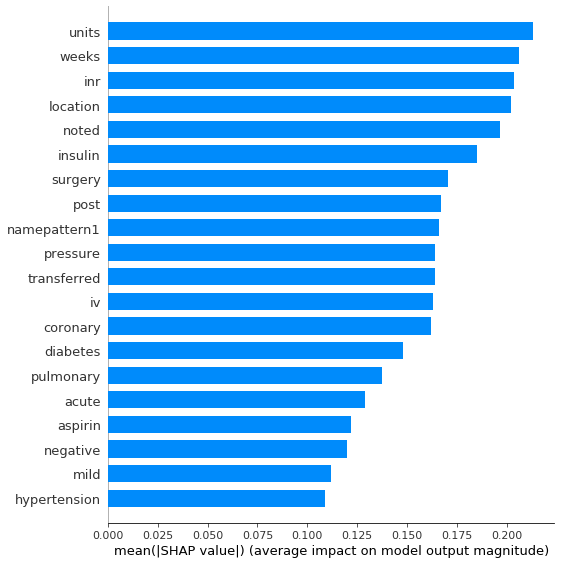

In [66]:
import shap
shap_values = shap.TreeExplainer(model_xg1).shap_values(X_train_cvec)
shap.summary_plot(shap_values, X_train_cvec, plot_type="bar", feature_names=cvec.get_feature_names())

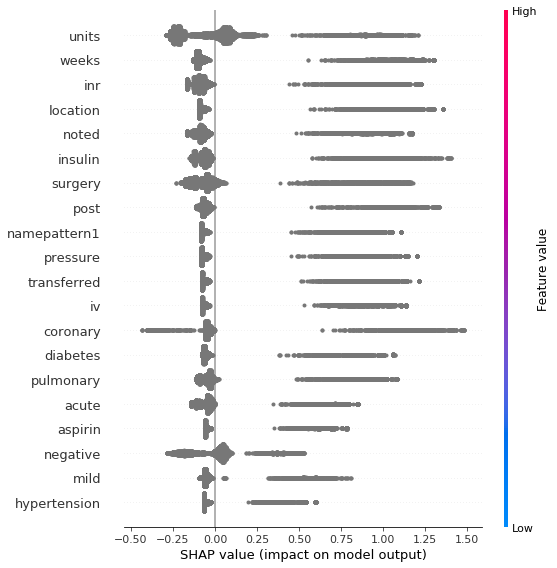

In [67]:
shap.summary_plot(shap_values, X_train_cvec,feature_names=cvec.get_feature_names())

### TfidfVectorizer

In [61]:
model_xg2 = XGBClassifier()
model_xg2.fit(X_train_tfidf, y_train_tfidf)
cross_val_acc2 = round(cross_val_score(model_xg2, X_train_tfidf, y_train_tfidf).mean(),4)
train_acc2 = round(model_xg2.score(X_train_tfidf,y_train_tfidf),4)
test_acc2 = round(model_xg2.score(X_test_tfidf,y_test_tfidf),4)
preds2 = model_xg2.predict(X_test_tfidf)
tn, fp, fn, tp = confusion_matrix(y_test_tfidf, preds2).ravel()

In [62]:
print(f' cross_val_acc = {cross_val_acc2}\n train_acc = {train_acc2} \n test_acc = {test_acc2}\n tn, fp, fn, tp {tn, fp, fn, tp}' )

 cross_val_acc = 0.9291
 train_acc = 0.943 
 test_acc = 0.9033
 tn, fp, fn, tp (1449, 61, 231, 1279)


## Machine Learning Classification Models: SVM

### CountVectorizer

In [73]:
svc1 =SVC(gamma = 'scale', random_state=42)
svc1.fit(X_train_cvec, y_train_cvec)

y_pred1 = svc.predict(X_test_cvec)
accuracy_score(y_test_cvec, y_pred1)

0.6903973509933775

In [76]:
tn, fp, fn, tp = confusion_matrix(y_test_cvec,y_pred1).ravel()
tn, fp, fn, tp

(1301, 209, 726, 784)

### TfidfVectorizer

In [77]:
svc2 =SVC(gamma = 'scale', random_state=42)
svc2.fit(X_train_tfidf, y_train_tfidf)

y_pred2 = svc.predict(X_test_tfidf)
print(round(accuracy_score(y_test_tfidf, y_pred2),4))
tn, fp, fn, tp = confusion_matrix(y_test_tfidf,y_pred2).ravel()
tn, fp, fn, tp

0.5


(0, 1510, 0, 1510)

## Machine Learning Classification Models: FFNN(feed forward neutral network)

In [79]:
n_input = X_train_cvec.shape[1]
n_input

100

In [97]:
model_ffnn = Sequential()

lam=0.09
model_ffnn.add(Dense(n_input,
                   input_dim = n_input,
                   activation = 'relu',
                   kernel_regularizer = regularizers.l2(lam)
                       ))
model_dropout = Sequential()
model_dropout.add(Dropout(0.5))
model_ffnn.add(Dense(1,
                   activation='sigmoid'))

model_ffnn.compile(loss='binary_crossentropy',
                 optimizer='adam',
                 metrics=['acc'])
early_stop = EarlyStopping(monitor = 'val_loss', 
                           min_delta=0, 
                           patience=5,
                           mode='auto')
history_all = model_ffnn.fit(X_train_cvec,
                          y_train_cvec,
                          validation_data=(X_test_cvec,y_test_cvec),
                          epochs=10,
                          batch_size=None,
                          verbose=2,
                          callbacks=[early_stop]
                          )

Train on 8996 samples, validate on 3020 samples
Epoch 1/10
 - 1s - loss: 3.6363 - acc: 0.6981 - val_loss: 1.4145 - val_acc: 0.6639
Epoch 2/10
 - 1s - loss: 0.9642 - acc: 0.7547 - val_loss: 0.9008 - val_acc: 0.7089
Epoch 3/10
 - 1s - loss: 0.6970 - acc: 0.7709 - val_loss: 0.8329 - val_acc: 0.6474
Epoch 4/10
 - 1s - loss: 0.6236 - acc: 0.7761 - val_loss: 0.7932 - val_acc: 0.6540
Epoch 5/10
 - 1s - loss: 0.5904 - acc: 0.7789 - val_loss: 0.7120 - val_acc: 0.6894
Epoch 6/10
 - 1s - loss: 0.5624 - acc: 0.7831 - val_loss: 0.6939 - val_acc: 0.7010
Epoch 7/10
 - 1s - loss: 0.5554 - acc: 0.7890 - val_loss: 0.6777 - val_acc: 0.7119
Epoch 8/10
 - 1s - loss: 0.5455 - acc: 0.7830 - val_loss: 0.7084 - val_acc: 0.6957
Epoch 9/10
 - 1s - loss: 0.5273 - acc: 0.8012 - val_loss: 0.6774 - val_acc: 0.6937
Epoch 10/10
 - 1s - loss: 0.5063 - acc: 0.8165 - val_loss: 0.6910 - val_acc: 0.6987


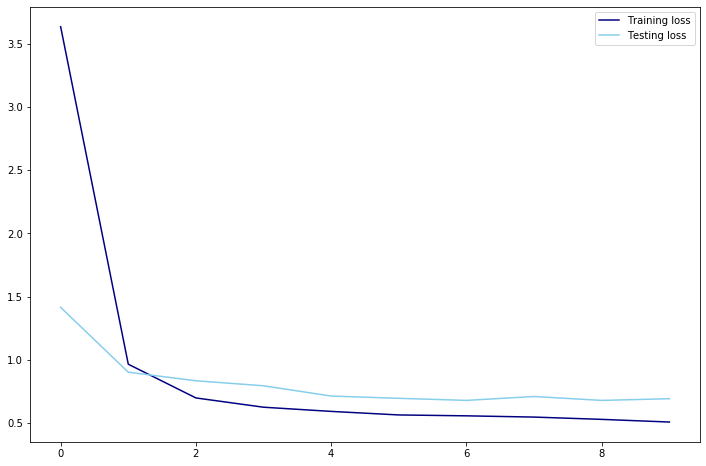

In [98]:
train_loss_all = history_all.history['loss']
test_loss_all = history_all.history['val_loss']
plt.figure(figsize=(12, 8))
plt.plot(train_loss_all, label='Training loss', color='navy')
plt.plot(test_loss_all, label='Testing loss', color='skyblue')
plt.legend();

In [99]:
history_all.history['acc'][-1], history_all.history['val_acc'][-1]

(0.81647396, 0.6986755132675171)